In [ ]:
import pandas as pd
import numpy as np
import copy
import pickle
from datetime import datetime

import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from xgboost import plot_importance
from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

Version: 1

Data description:
- 360 properties
- ALL transactions from 2015
- A single POI: distance to the near station

In [ ]:
def date_to_year(date_string):
    fmt = '%Y-%m-%d'
    return datetime.strptime(date_string,fmt).year

In [ ]:
Data = pd.read_csv('datasetV1.csv') 

In [ ]:
Data['transferYear']=Data['dateoftransfer'].apply(lambda x : date_to_year(x))

Removing irrelevant attributes

In [ ]:
dropList=['Unnamed: 0','LMK_KEY','BUILDING_REFERENCE_NUMBE','ADDRESS','postcode','LOCAL_AUTHORITY_LABEL','POSTTOWN',
         'place_id','code','postcode_Latitude','postcode_Longitude','MSOA_Code','LSOA_Code','dateoftransfer','transactionid',
          'INSPECTION_DATE','ptal_y', 'flood_risk_y',]
Data.drop(dropList, axis = 1, inplace = True)

Adding the Price per square foot

In [ ]:
Data['sq_PricePaid']=Data['PricePaid']/Data['TOTAL_FLOOR_AREA']

No handles with labels found to put in legend.


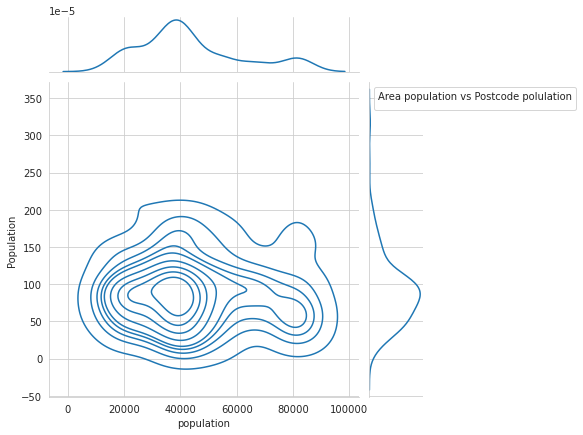

In [ ]:
sns.jointplot(x ='population', y ='Population', data = Data, kind ='kde')
plt.legend(title='Area population vs Postcode polulation')

### sq_PricePaid statistics -  Price per square foot

In [ ]:
Data['sq_PricePaid'].describe()

count      360.000000
mean      7652.174847
std       4550.769014
min        400.000000
25%       4850.281762
50%       6871.926230
75%       8936.170213
max      33333.333333
Name: sq_PricePaid, dtype: float64

No handles with labels found to put in legend.


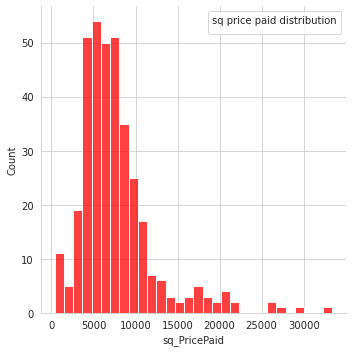

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['sq_PricePaid'], kde = False, color ='red', bins = 30)
plt.legend(title='sq price paid distribution')

No handles with labels found to put in legend.


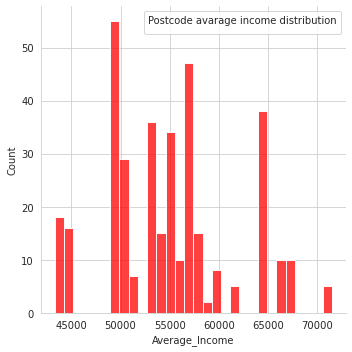

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['Average_Income'], kde = False, color ='red', bins = 30)
plt.legend(title='Postcode average income distribution')

No handles with labels found to put in legend.


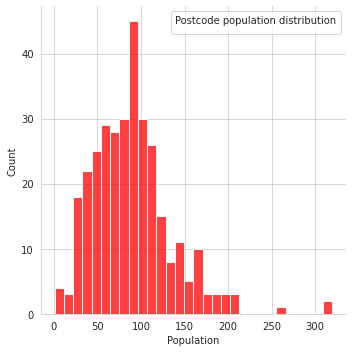

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['Population'], kde = False, color ='red', bins = 30)
plt.legend(title='Postcode population distribution')

No handles with labels found to put in legend.


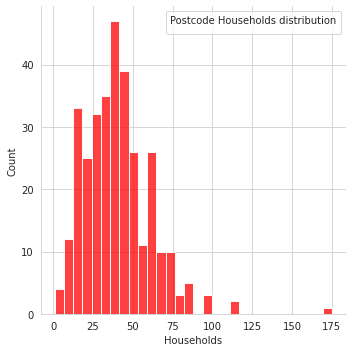

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['Households'], kde = False, color ='red', bins = 30)
plt.legend(title='Postcode Households distribution')

No handles with labels found to put in legend.


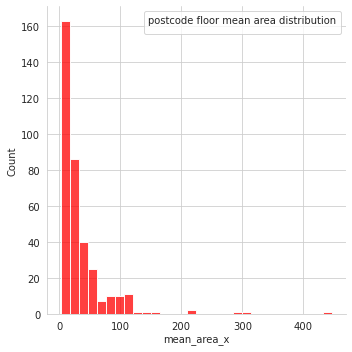

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['mean_area_x'], kde = False, color ='red', bins = 30)
plt.legend(title='postcode floor mean area distribution')

No handles with labels found to put in legend.


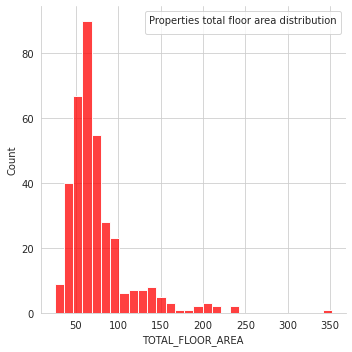

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['TOTAL_FLOOR_AREA'], kde = False, color ='red', bins = 30)
plt.legend(title='Properties total floor area distribution')

No handles with labels found to put in legend.


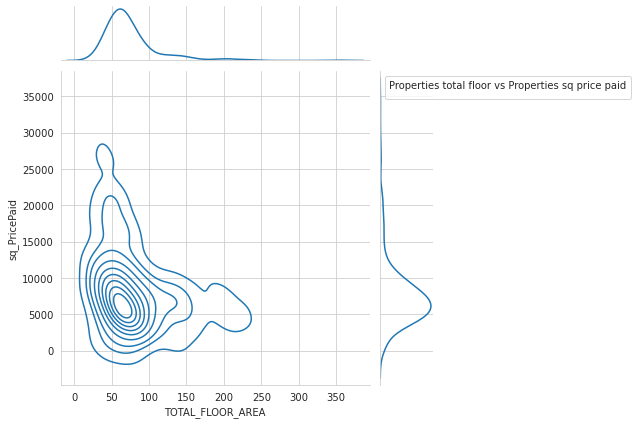

In [ ]:
sns.jointplot(x ='TOTAL_FLOOR_AREA', y ='sq_PricePaid', data = Data, kind ='kde')
plt.legend(title='Properties total floor vs Properties sq price paid')

### Categorical attribute binarization

In [ ]:

lbl = preprocessing.LabelEncoder()

catData = ['propertytype', 'oldnew', 'duration', 'categorytype', 'PROPERTY_TYPE', 'CONSTITUENCY', 'COUNTY', 'CONSTRUCTION_AGE_BAND', 'CURRENT_ENERGY_RATING', 'CONSTITUENCY_LABEL', 'crime_rating', 'ptal_x', 'flood_risk_x']
for att in catData:
    unique_classes = Data[att].unique()
    one_hot = pd.get_dummies(unique_classes, prefix=att,dummy_na=True, columns = [att])
    one_hot[att] = unique_classes
    Data = Data.merge(one_hot, on = [att], how='left')
    Data = Data.drop(columns = [att])

### Define sq_price as the model goal 

In [ ]:
Data['sq_price'] = Data['sq_PricePaid']
Data.drop('sq_PricePaid',  axis = 1, inplace = True)
Data.drop('PricePaid', axis = 1, inplace = True)

### Attributes used for the model

In [ ]:
list(Data.columns)

['TOTAL_FLOOR_AREA',
 'Year_1_Value',
 'Year_2_Value',
 'Year_2_growth',
 'Year_3_Value',
 'Year_3_growth',
 'Year_4_Value',
 'Year_4_growth',
 'Year_5_Value',
 'Year_5_growth',
 'population',
 'crimes_last_12m',
 'crimes_per_thousand',
 'PublicOrder',
 'Burglary',
 'Robbery',
 'PossessionOfWeapons',
 'BicycleTheft',
 'AntiSocialBehaviour',
 'Violence',
 'Theft',
 'Shoplifting',
 'OtherCrime',
 'Drugs',
 'OtherTheft',
 'VehicleCrime',
 'CriminalDamage',
 'deprivation',
 'health',
 'age0_4',
 'age5_9',
 'age10_14',
 'age15_19',
 'age20_24',
 'age25_29',
 'age30_34',
 'age35_39',
 'age40_44',
 'age45_49',
 'age50_54',
 'age60_64',
 'age70_74',
 'age75_79',
 'age80_84',
 'age85_89',
 'proportion_with_degree',
 'vehicles_per_household',
 'commute_method_foot',
 'commute_method_bicycle',
 'commute_method_other',
 'commute_method_motorcycle',
 'commute_method_taxi',
 'commute_method_train',
 'commute_method_bus',
 'commute_method_underground_light_rail',
 'commute_method_car_driver',
 'commu

In [ ]:
# Split data
X, y = Data.iloc[:, :-1], Data.iloc[:, -1]

In [ ]:
# Splitting
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                      test_size = 0.3, random_state = 123)

In [ ]:
  # Train and test set are converted to DMatrix objects,
# as it is required by learning API.
train_dmatrix = xg.DMatrix(data = train_X, label = train_y)
test_dmatrix = xg.DMatrix(data = test_X, label = test_y)
  
# Parameter dictionary specifying base learner
param = {"objective":"reg:squarederror"} # "booster":"gblinear"
  
xgb_r = xg.train(params = param, dtrain = train_dmatrix, num_boost_round = 10)

In [ ]:
pred = xgb_r.predict(test_dmatrix)

In [ ]:
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

RMSE :  3117.247876


In [ ]:
print("Mean: %f" %((rmse/7652.174847)*100),"%")

Mean: 40.736757 %


### Plot feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

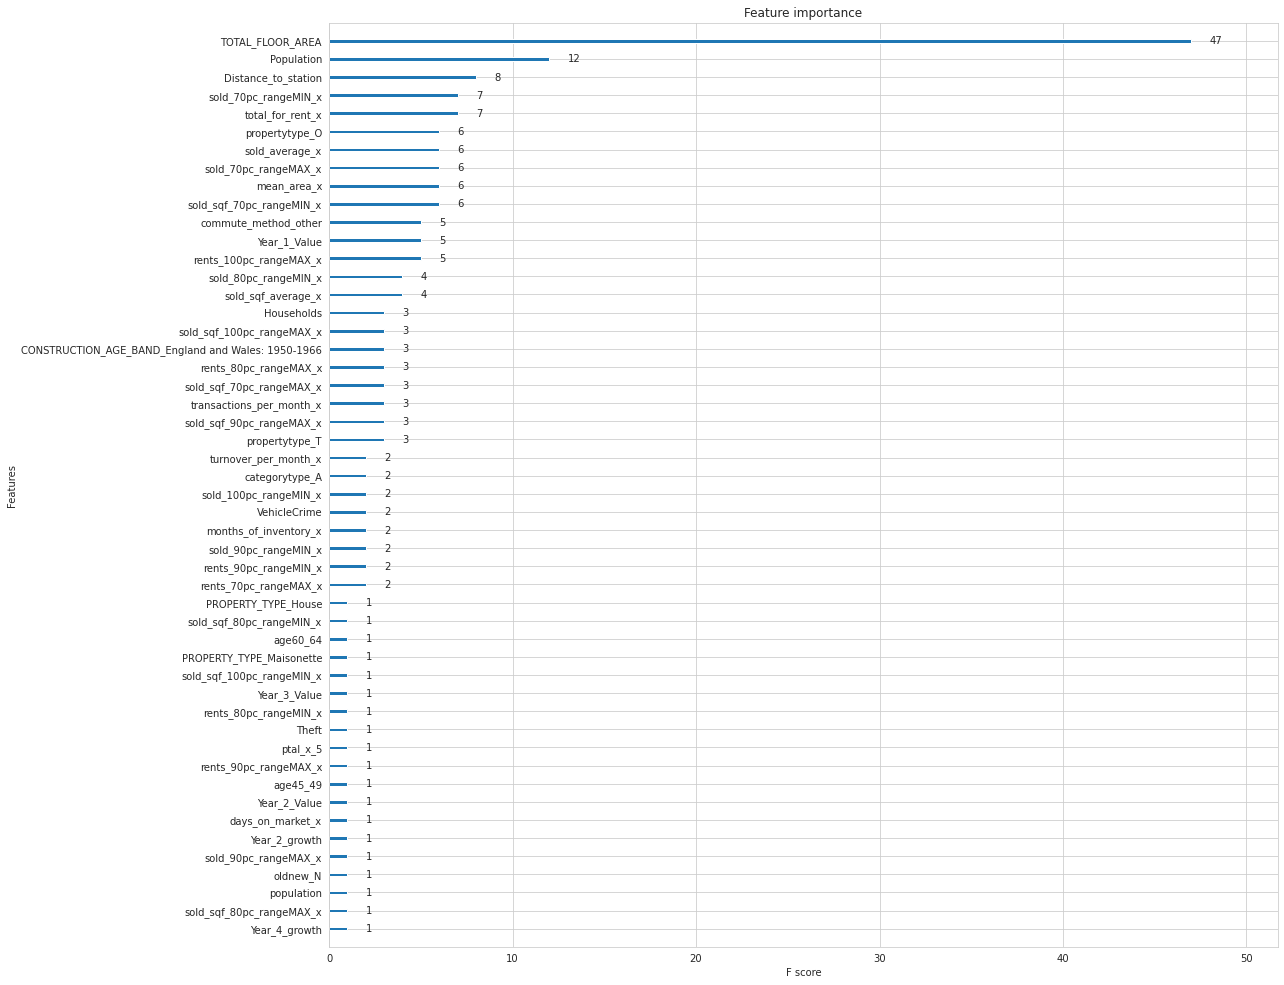

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,17))

xg.plot_importance(xgb_r, ax)

/home/carlos/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'row'
  cset = contour_func(
No handles with labels found to put in legend.


Text(0.5, 32.99999999999995, 'real sq price')

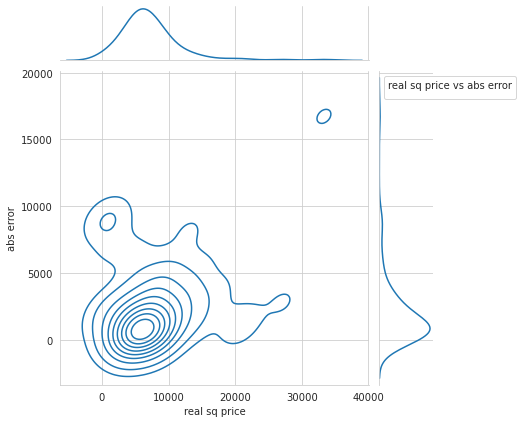

In [ ]:
h=sns.jointplot(x = test_y, y = np.abs(test_y-pred), kind ='kde', row="day")
plt.legend(title='real sq price vs abs error')
h.ax_joint.set_ylabel('abs error')
h.ax_joint.set_xlabel('real sq price')

No handles with labels found to put in legend.


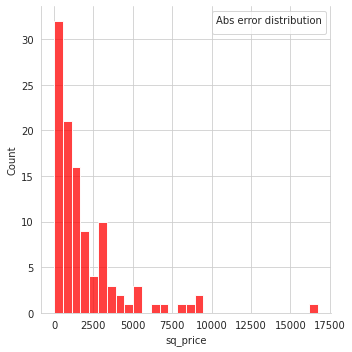

In [ ]:
sns.set_style('whitegrid')
h=sns.displot(np.abs(test_y-pred), kde = False, color ='red', bins = 30)
plt.legend(title='Abs error distribution')